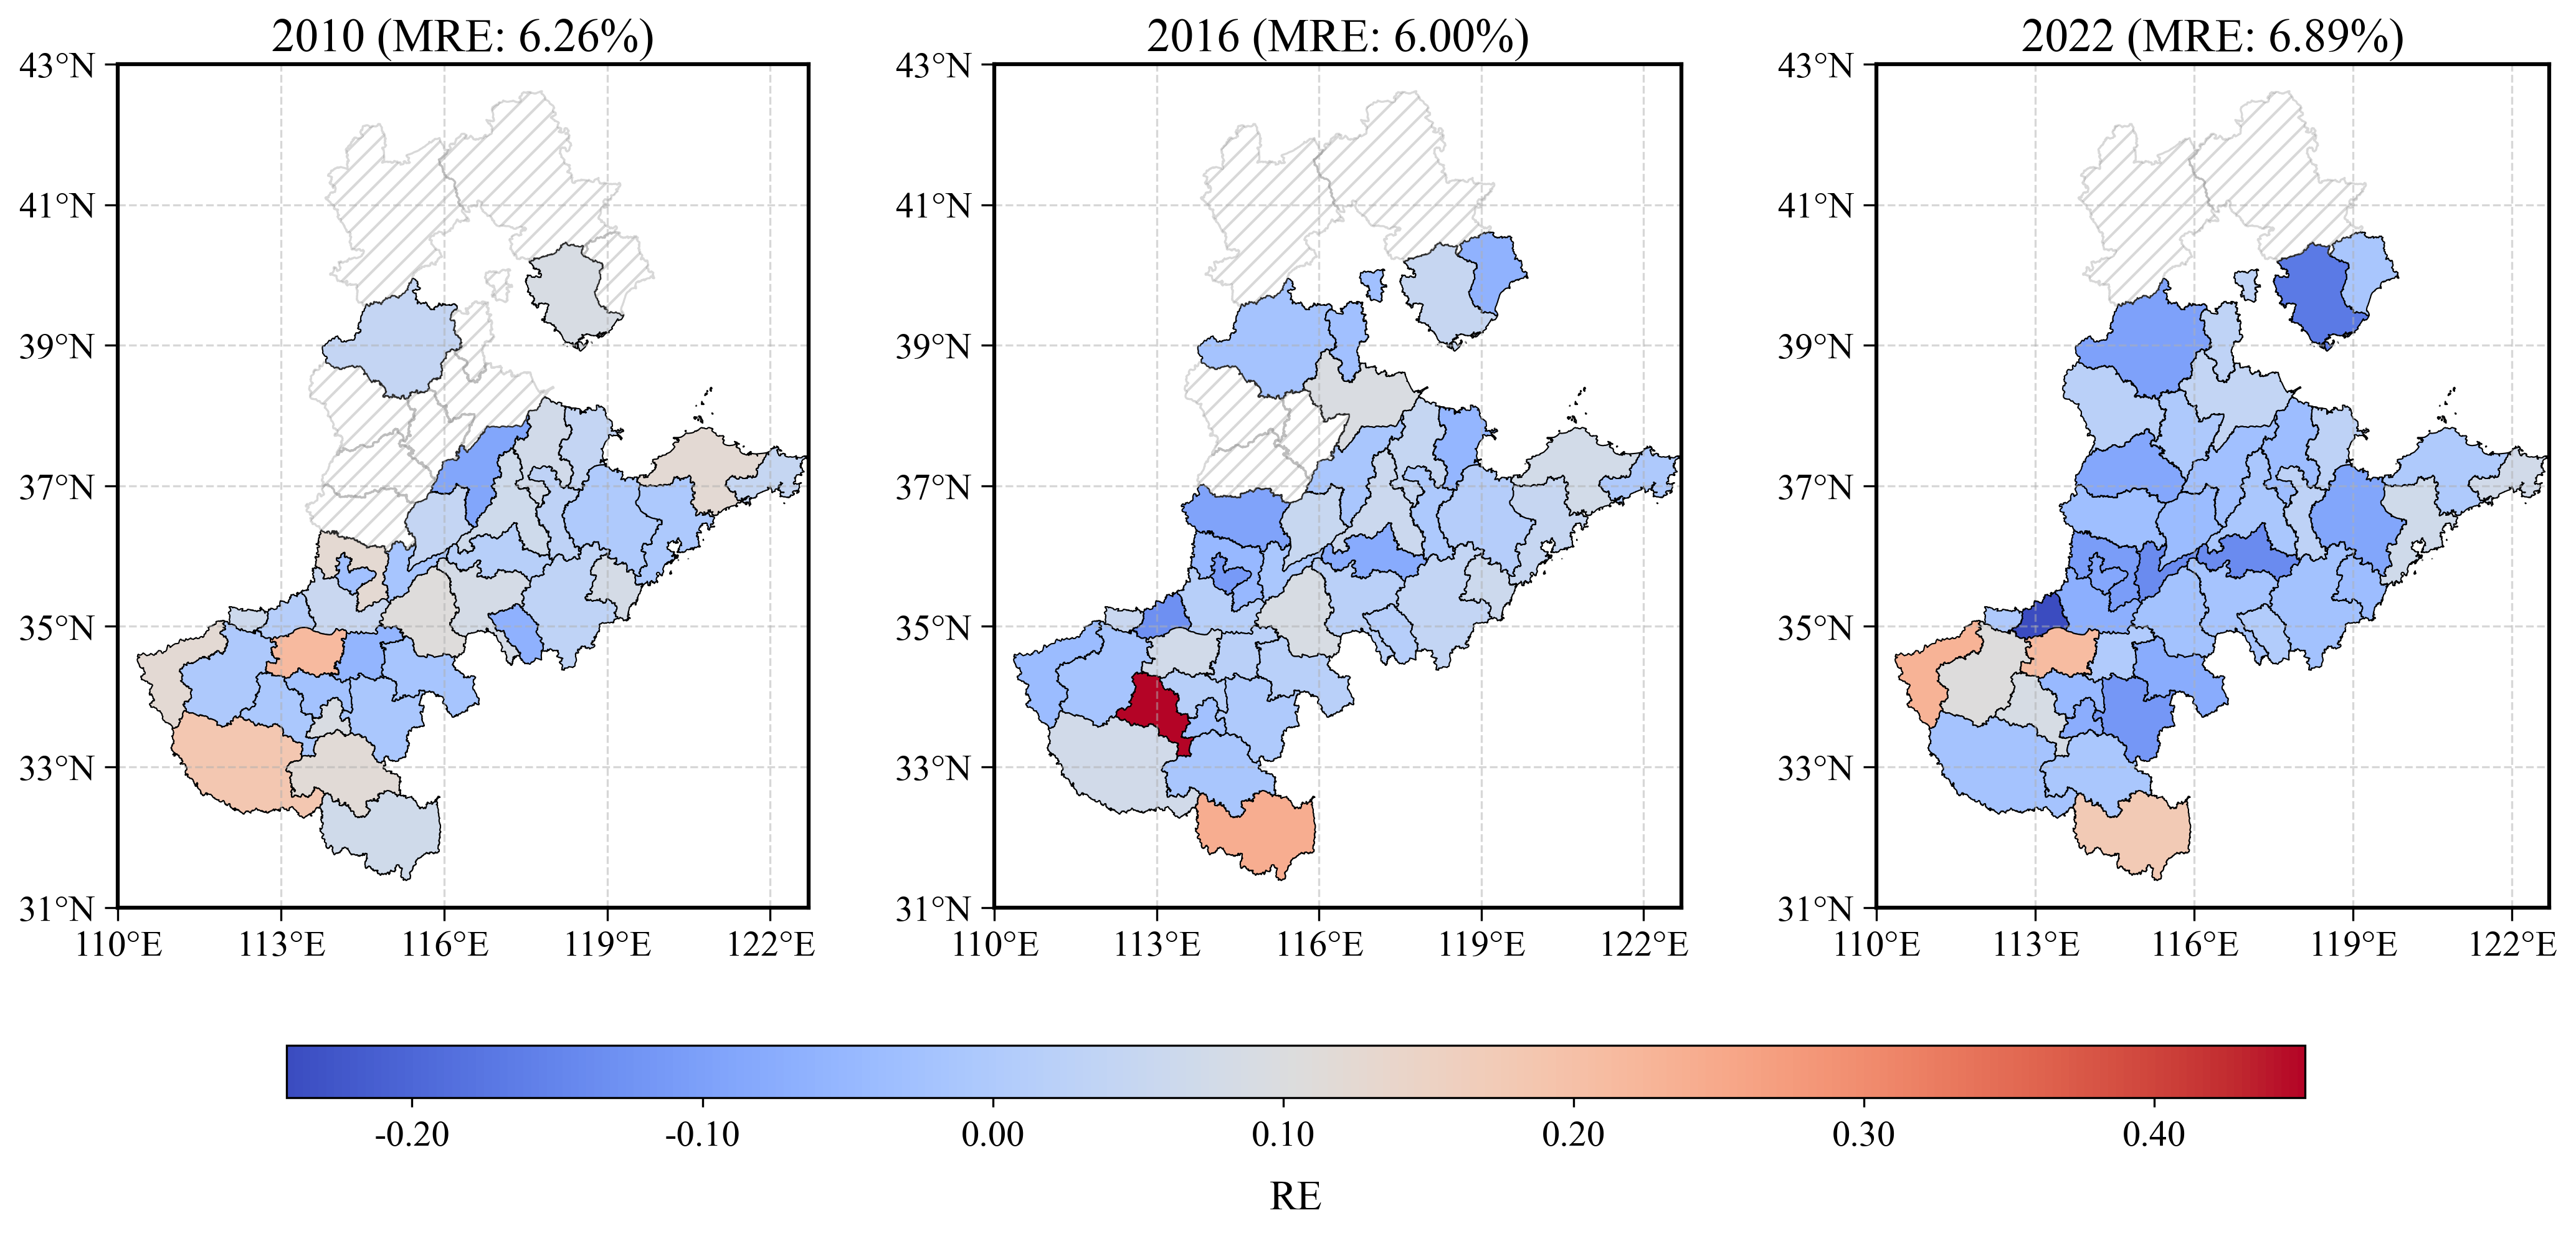

In [99]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import warnings
from matplotlib.patches import Patch

# 1. 全局字体设置
try:
    rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei']
    rcParams['axes.unicode_minus'] = False
except Exception as e:
    warnings.warn(f"字体设置失败: {str(e)}")

# 2. 参数设置
base_path = r"D:\python\crop_yield_prediction"
years = [2010, 2016, 2022]
shapefile_path = "D:/Crop/NCC/NCC.shp"

# 3. 数据加载函数
def safe_load(year):
    try:
        df = pd.read_excel(f"{base_path}/{year}年产量预测评估_3DCNN_xLSTM.xlsx")
        df[['province_code', 'city_code']] = df[['province_code', 'city_code']].astype(int)
        return df
    except Exception as e:
        warnings.warn(f"{year}年数据加载失败: {str(e)}")
        return pd.DataFrame()

# 4. 主绘图函数
def plot_comparison():
    # 准备地理数据
    gdf = gpd.read_file(shapefile_path)
    gdf[['province_code', 'city_code']] = gdf[['省级码', '区划码']].astype(int)
    
    # 计算全局地理范围
    total_bounds = gdf.total_bounds
    min_lon, min_lat, max_lon, max_lat = total_bounds
    
    # 创建画布（调整宽高比）
    fig = plt.figure(figsize=(18, 7), dpi=300, facecolor='white')  # 增加高度
    gs = fig.add_gridspec(2, 3, height_ratios=[0.9, 0.1], hspace=0.15, wspace=0.02)
    axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
    #cbar_ax = fig.add_subplot(gs[1, :])
    
    # 添加主标题（调整位置）
    #fig.suptitle('各省地级市产量预测误差对比 (2010-2022)', y=0.95, fontsize=20)
    
    # 计算全局误差范围
    error_range = []
    for year in years:
        merged = gdf.merge(safe_load(year), on=['province_code', 'city_code'], how='left')
        error = (merged['预测值'] - merged['真实值']) / merged['真实值']
        error_range.extend(error.dropna().tolist())
    
    vmin, vmax = min(error_range), max(error_range)
    
    # 设置地理刻度参数
    lon_step = 3  # 经度间隔
    lat_step = 2  # 纬度间隔
    
    # 生成经纬度刻度
    lon_ticks = np.arange(np.floor(min_lon), np.ceil(max_lon)+1, lon_step)
    lat_ticks = np.arange(np.floor(min_lat), np.ceil(max_lat)+1, lat_step)
    
    # # 创建缺失数据的图例元素
    # no_data_patch = Patch(facecolor='none', edgecolor='gray', 
    #                      linewidth=0.8, hatch='////', alpha=0.3, label='缺失数据')
    
    # 绘制每个年份
    for ax, year in zip(axs, years):
        data = safe_load(year)
        if data.empty:
            continue
            
        merged = gdf.merge(data, on=['province_code', 'city_code'], how='left')
        merged['error'] = (merged['预测值'] - merged['真实值']) / merged['真实值']
        mre = (merged['error'].abs().mean()) * 100  # 计算平均绝对相对误差

        # 绘制有数据区域
        valid = merged[merged['error'].notna()]
        if not valid.empty:
            valid.plot(column='error', ax=ax, cmap='coolwarm', 
                      vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.5)
        
        # 绘制无数据区域
        invalid = merged[merged['error'].isna()]
        if not invalid.empty:
            invalid.plot(ax=ax, facecolor='none', edgecolor='gray', 
                        linewidth=0.8, hatch='///', alpha=0.3)
        
        # 设置地理范围和坐标轴
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # 设置经纬度刻度
        ax.set_xticks(lon_ticks)
        ax.set_yticks(lat_ticks)
        ax.set_xticklabels([f'{x:.0f}°E' for x in lon_ticks], fontsize=14)
        ax.set_yticklabels([f'{y:.0f}°N' for y in lat_ticks], fontsize=14)
        
        # 美化坐标轴
        ax.tick_params(axis='both', which='both', length=5)
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color('black')
        
        ax.set_title(f'{year} (MRE: {mre:.2f}%)', fontsize=18, pad=5)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    # 添加颜色条（使用专门的轴）
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array(error_range)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array(error_range)
    # 创建专门的颜色条轴（调整width和height参数控制大小）
    cbar_ax = fig.add_axes([0.2, 0.09, 0.6, 0.04])  # [left, bottom, width, height]
    cbar = fig.colorbar(
        sm, 
        cax=cbar_ax, 
        orientation='horizontal', 
        format='%.2f'  # 设置刻度格式
    )
    cbar.set_label('RE', fontsize=16, labelpad=10)
    cbar.ax.tick_params(labelsize=14, pad=5)
    # 调整颜色条刻度密度（可选）
    #cbar.locator = plt.MaxNLocator(nbins=5)  # 设置刻度数量
    cbar.update_ticks()

    # 添加图例（使用单独的轴）
    legend_ax = fig.add_axes([0.3, 0.11, 0.4, 0.04])  # 调整图例位置和大小
    legend_ax.axis('off')
    # legend = legend_ax.legend(handles=[no_data_patch], labels=['缺失数据'], 
    #                         loc='center', frameon=False, fontsize=12, 
    #                         handlelength=3, handleheight=2)
    
    # 调整布局
    #plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.09)  # 增加底部空间

# 执行绘图
plot_comparison()
plt.show()

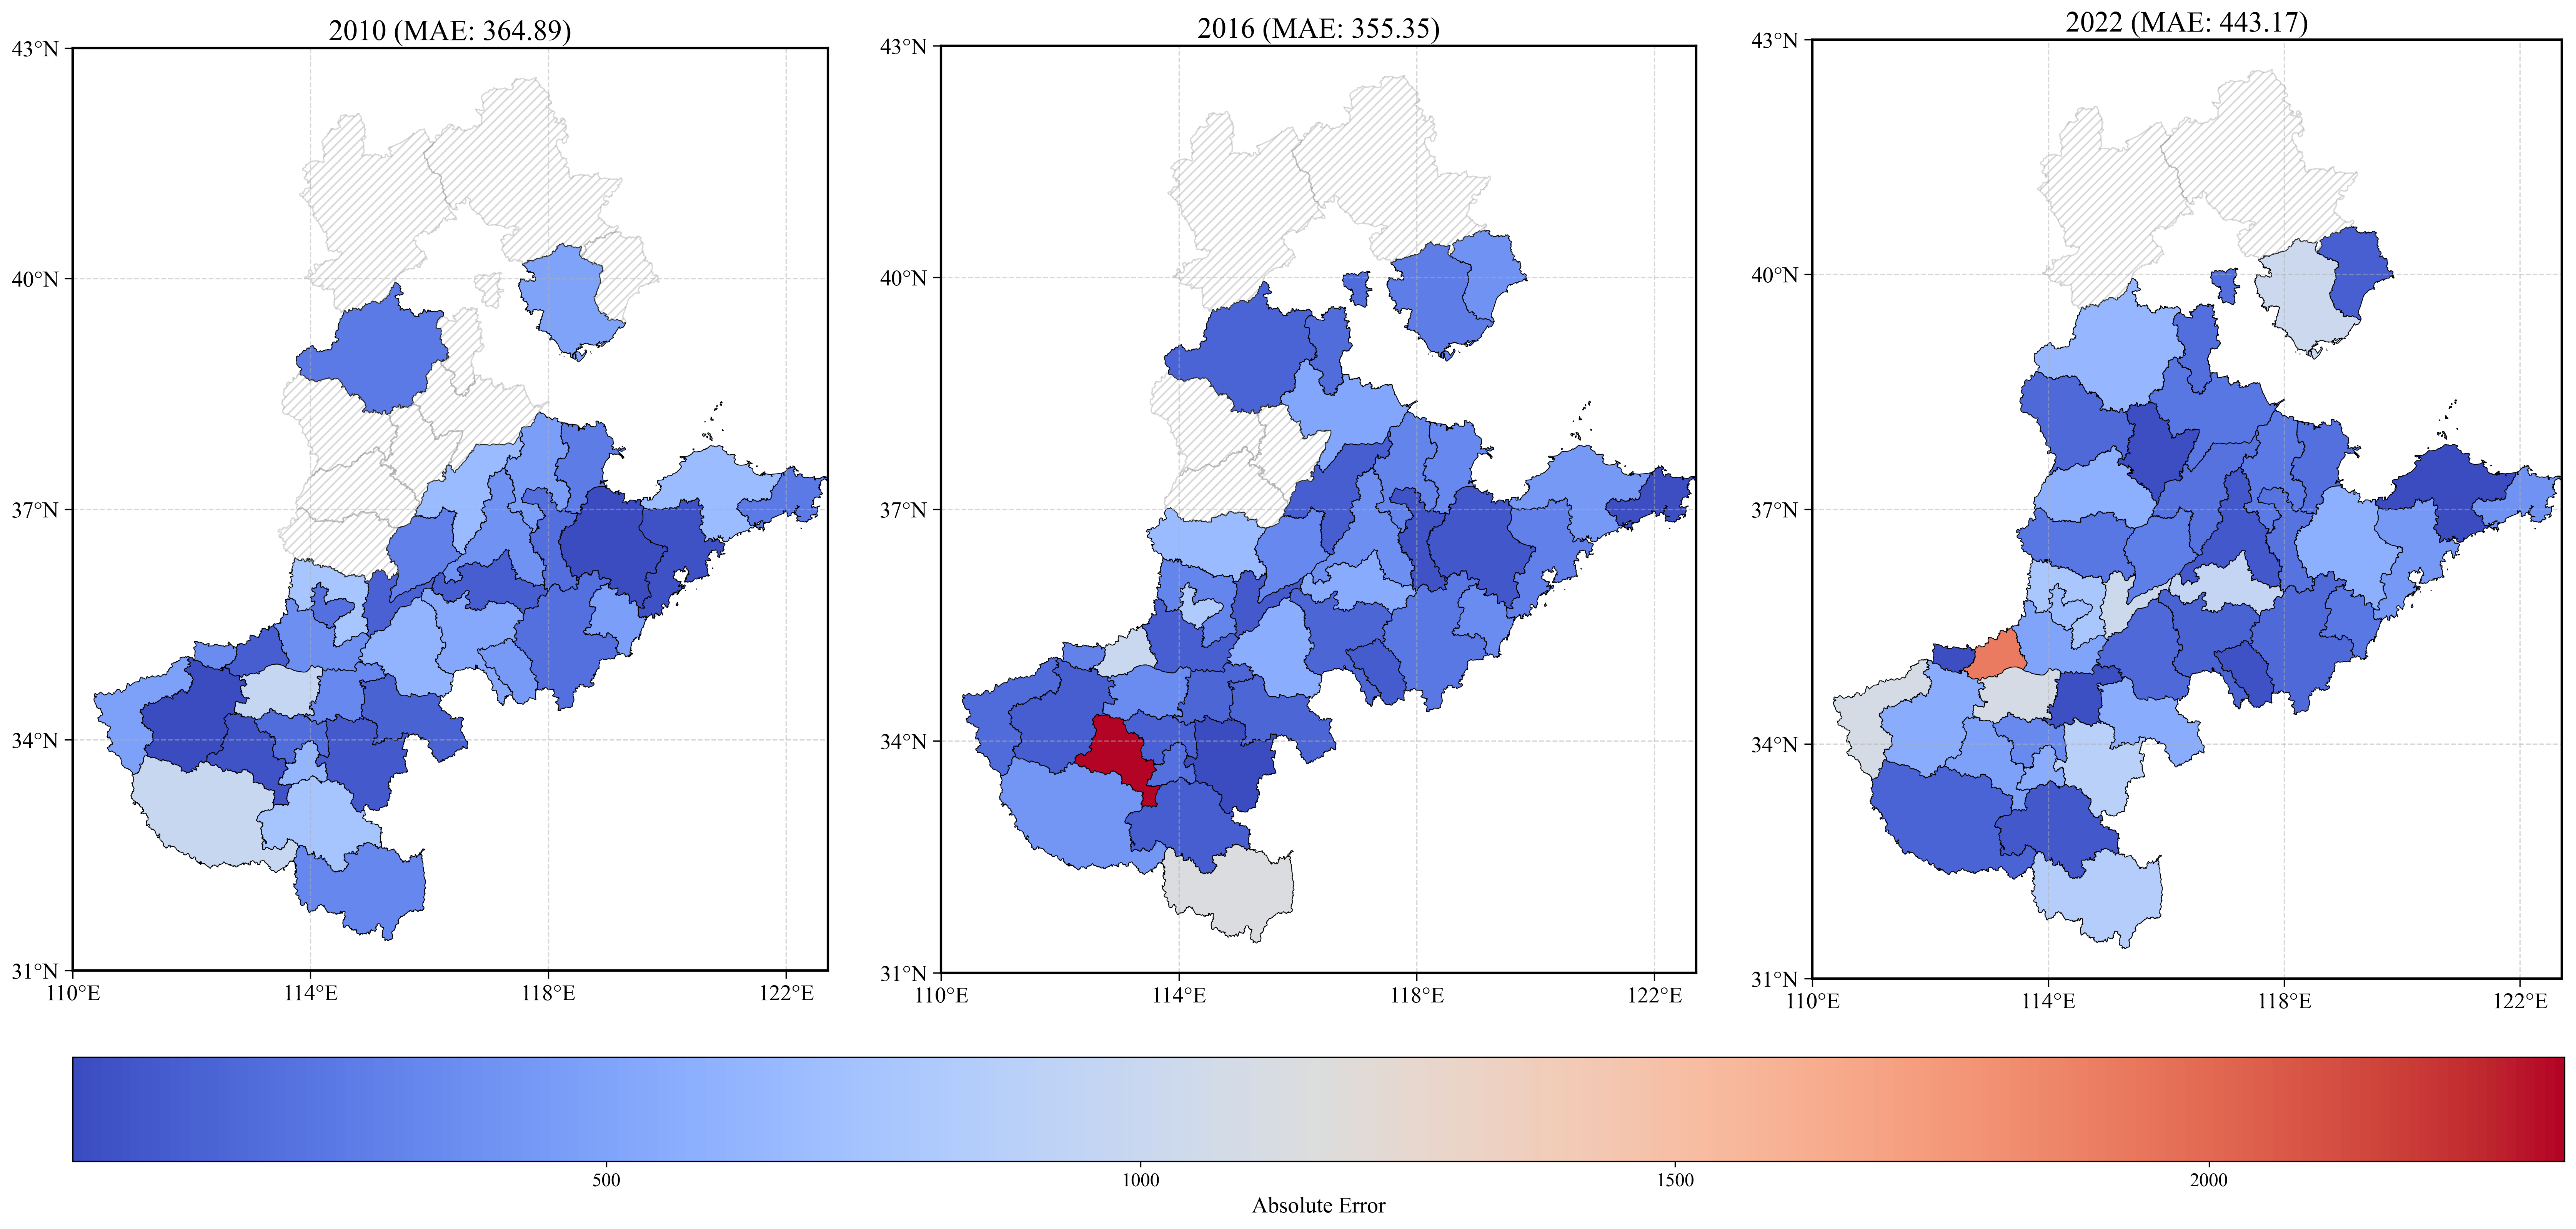

In [68]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import warnings
from matplotlib.patches import Patch

# 1. 全局字体设置
try:
    rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei']
    rcParams['axes.unicode_minus'] = False
except Exception as e:
    warnings.warn(f"字体设置失败: {str(e)}")

# 2. 参数设置
base_path = r"D:\python\crop_yield_prediction"
years = [2010, 2016, 2022]
shapefile_path = "D:/Crop/NCC/NCC.shp"

# 3. 数据加载函数
def safe_load(year):
    try:
        df = pd.read_excel(f"{base_path}/{year}年产量预测评估_3DCNN_xLSTM.xlsx")
        df[['province_code', 'city_code']] = df[['province_code', 'city_code']].astype(int)
        return df
    except Exception as e:
        warnings.warn(f"{year}年数据加载失败: {str(e)}")
        return pd.DataFrame()

# 4. 主绘图函数
def plot_comparison():
    # 准备地理数据
    gdf = gpd.read_file(shapefile_path)
    gdf[['province_code', 'city_code']] = gdf[['省级码', '区划码']].astype(int)
    
    # 计算全局地理范围
    total_bounds = gdf.total_bounds
    min_lon, min_lat, max_lon, max_lat = total_bounds
    
    # 创建画布（调整宽高比）
    fig = plt.figure(figsize=(24, 12), dpi=300, facecolor='white')  # 增加高度
    gs = fig.add_gridspec(2, 3, height_ratios=[0.9, 0.1], hspace=0.15, wspace=0.15)
    axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
    cbar_ax = fig.add_subplot(gs[1, :])
    
    # 计算全局误差范围
    error_range = []
    for year in years:
        merged = gdf.merge(safe_load(year), on=['province_code', 'city_code'], how='left')
        # 计算绝对误差 |预测值 - 真实值|
        abs_error = (merged['预测值'] - merged['真实值']).abs()
        error_range.extend(abs_error.dropna().tolist())
    
    vmin, vmax = min(error_range), max(error_range)
    
    # 设置地理刻度参数
    lon_step = 4  # 经度间隔
    lat_step = 3  # 纬度间隔
    
    # 生成经纬度刻度
    lon_ticks = np.arange(np.floor(min_lon), np.ceil(max_lon)+1, lon_step)
    lat_ticks = np.arange(np.floor(min_lat), np.ceil(max_lat)+1, lat_step)
    
    # 绘制每个年份
    for ax, year in zip(axs, years):
        data = safe_load(year)
        if data.empty:
            continue
            
        merged = gdf.merge(data, on=['province_code', 'city_code'], how='left')
        # 计算绝对误差 |预测值 - 真实值|
        merged['error'] = (merged['预测值'] - merged['真实值']).abs()
        mae = merged['error'].mean()  # 计算MAE（平均绝对误差）
        
        # 绘制有数据区域
        valid = merged[merged['error'].notna()]
        if not valid.empty:
            valid.plot(column='error', ax=ax, cmap='coolwarm', 
                      vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.5)
        
        # 绘制无数据区域
        invalid = merged[merged['error'].isna()]
        if not invalid.empty:
            invalid.plot(ax=ax, facecolor='none', edgecolor='gray', 
                        linewidth=0.8, hatch='////', alpha=0.3)
        
        # 设置地理范围和坐标轴
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # 设置经纬度刻度
        ax.set_xticks(lon_ticks)
        ax.set_yticks(lat_ticks)
        ax.set_xticklabels([f'{x:.0f}°E' for x in lon_ticks], fontsize=14)
        ax.set_yticklabels([f'{y:.0f}°N' for y in lat_ticks], fontsize=14)
        
        # 美化坐标轴
        ax.tick_params(axis='both', which='both', length=5)
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color('black')
        
        ax.set_title(f'{year} (MAE: {mae:.2f})', fontsize=18, pad=5)  # 显示MAE
        ax.grid(True, linestyle='--', alpha=0.5)
    
    # 添加颜色条（使用专门的轴）
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array(error_range)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Absolute Error', fontsize=14)  # 改为"Absolute Error"
    cbar.ax.tick_params(labelsize=12)
    
    # 调整布局
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.09)

# 执行绘图
plot_comparison()
plt.show()